# Segunda parte: Aspectos prácticos de las redes neuronales

En esta segunda parte, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el tema

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
# Puedes añadir todos los imports adicionales que necesites aquí
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

4422102/4422102 [==============================] - 0s 0us/step


## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out [texto del enlace](https://)data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [3]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.rcParams['figure.figsize'] = (10, 8)  
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.rcParams['figure.figsize'] = (10, 8)  
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

In [4]:
from keras.optimizers import RMSprop, SGD

epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1 ****: Partiendo de una red sencilla como la desarrollada en la actividad 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.



In [5]:
#Tenemos 10 clases que varian de 0 a 9 como hemos visto en los puntos anteriores.
num_clases=10

#Transformamos el formato de las imagenes de un vector bi-dimensional (de 28 por 28 pixeles) a un vector unidimensional (de 28*28 pixeles = 784 pixeles)
x_train_total = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

#Transformamos el vector de la variable y es categorico.
y_train_total = keras.utils.to_categorical(y_train, num_clases)
y_test = keras.utils.to_categorical(y_test, num_clases)

#Reservamos el 20 % que serian 12000 imagenes para validación.
x_val = x_train_total[-12000:]
y_val = y_train_total[-12000:]
x_train = x_train_total[:-12000]
y_train = y_train_total[:-12000]

### Experimento 1 - Sigmoid vs Relu





In [6]:

model = Sequential()
model.add(Dense(128,activation='sigmoid', input_shape=(784,)))
model.add(Dense(64,activation='sigmoid'))
model.add(Dense(num_clases,activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),            
              metrics=['accuracy'])


history_sigmoid = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 5s 5ms/step - loss: 2.2072 - accuracy: 0.3730 - val_loss: 2.0799 - val_accuracy: 0.5587
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 1.9060 - accuracy: 0.5584 - val_loss: 1.7184 - val_accuracy: 0.5195
Epoch 3/20
750/750 [==========

In [7]:
# Probando ReLU

model = Sequential()
model.add(Dense(128,activation='relu', input_shape=(784,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(num_clases,activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),            
              metrics=['accuracy'])


history_relu = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 1.0103 - accuracy: 0.6770 - val_loss: 0.6511 - val_accuracy: 0.7802
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.5911 - accuracy: 0.8008 - val_loss: 0.5501 - val_accuracy: 0.8062
Epoch 3/20
750/750 [========

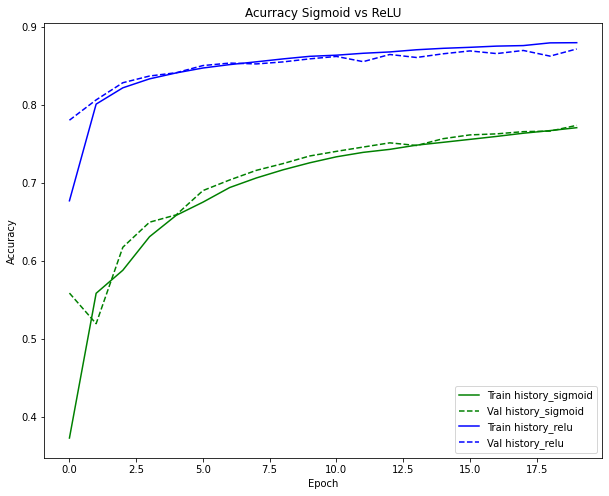

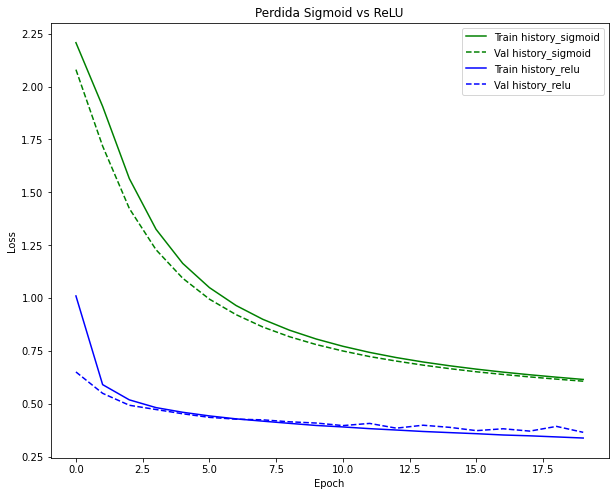

In [8]:
#Vamos a comparar el accuracy y las perdidas de cada modelo.
plot_compare_accs(history_sigmoid, history_relu, name1="history_sigmoid",name2="history_relu", title="Acurracy Sigmoid vs ReLU")
plot_compare_losses(history_sigmoid, history_relu, name1="history_sigmoid",name2="history_relu", title="Perdida Sigmoid vs ReLU")

#### Conclusión 
En ambos gráficos podemos ver lo bien que se comporta ReLU con respecto a Sigmoid. Esta última tiende a saturarse cuando sus valores tienden a 0 o a 1, pequeños cambios en x no implicación en y. Al estar saturada la derivada es prácticamente 0, entonces el gradiente resultante es aproximadamente es 0 con esto tenemos el efecto que eliminamos la señal de aprendizaje. Otro de los problemas que se puede apreciar en esta práctica es que la señal no esta centrada en 0, esto provoca que los valores siempre sean positivos, estas salidas positivas provocan que el fenómeno en las siguientes capas. Por último, también tienen problema con la complejidad de operaciones, pero este no lo hemos apreciado en esta práctica, ya que la red es muy pequeña. Ambas se han comportado entornos a 2s por época.
Por otro lado ReLU no satura en régimen positivo ya que x>0, por otro lado al ser una función lineal y centrada en 0 tampoco tiene problemas en la aproximaciones a 0 o 1. 

### Experimento 2 - Relu vs Tangente Hiperbólica  



In [9]:
# Probando tanh

model = Sequential()
model.add(Dense(128,activation='tanh', input_shape=(784,)))
model.add(Dense(64,activation='tanh'))
model.add(Dense(num_clases,activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),            
              metrics=['accuracy'])


history_tanh = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.8844 - accuracy: 0.7163 - val_loss: 0.6390 - val_accuracy: 0.7859
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.5815 - accuracy: 0.8039 - val_loss: 0.5434 - val_accuracy: 0.8112
Epoch 3/20
750/750 [========

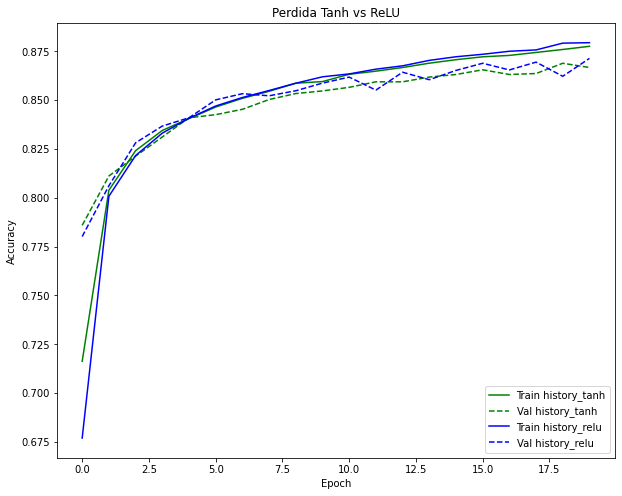

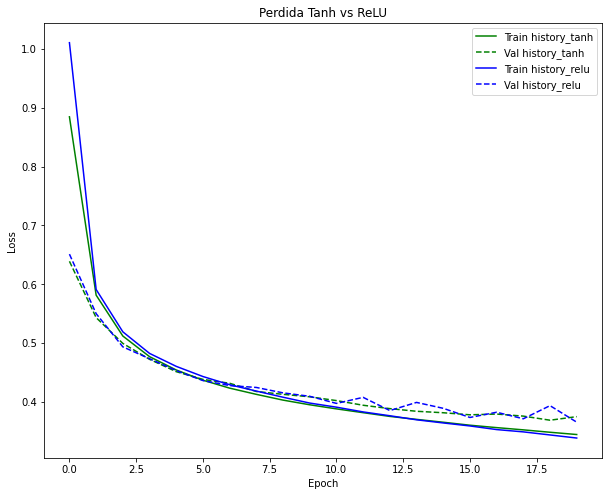

In [10]:
#Vamos a comparar los
plot_compare_accs(history_tanh, history_relu, name1="history_tanh",name2="history_relu", title="Perdida Tanh vs ReLU")
plot_compare_losses(history_tanh, history_relu, name1="history_tanh",name2="history_relu", title="Perdida Tanh vs ReLU")


#### Conclusión
Ahora estamos comparando ReLU con tanh (Tangente hiperbólica). En ambas gráficas se puede observar que el rendimiento de ReLU es mejor, pero no con tanta diferencia como con Sigmoid. Tanh sigue teniendo el problema de que “mata” gradientes, pero por el contrario esta centrada en 0. Por lo que en este experimento se puede sacar la conclusión que hay mayor mejoria por que la señal de activación este centrada en 0, que por que la derivada local tienda a 0 en los extremos.

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2 **: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

### Experimento 3 - Zero vs Glorot uniform vs Aleatoria Normal


In [11]:
def modelo_ejercicio2():

  print(activation)
  print(initialization)
  model = Sequential()
  model.add(Dense(128,kernel_initializer=initialization,activation=activation, input_shape=(784,)))
  model.add(Dense(64,kernel_initializer=initialization,activation=activation))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),            
              metrics=['accuracy'])


  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [12]:
activation='relu'
initialization='random_normal'
history_normal=modelo_ejercicio2()
initialization='zero'
history_zero=modelo_ejercicio2()
initialization='glorot_uniform'
history_glorot=modelo_ejercicio2()

relu
random_normal
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 1.0965 - accuracy: 0.6658 - val_loss: 0.7077 - val_accuracy: 0.7592
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6431 - accuracy: 0.7835 - val_loss: 0.5907 - val_accuracy: 0.7975
Epoch 3/2

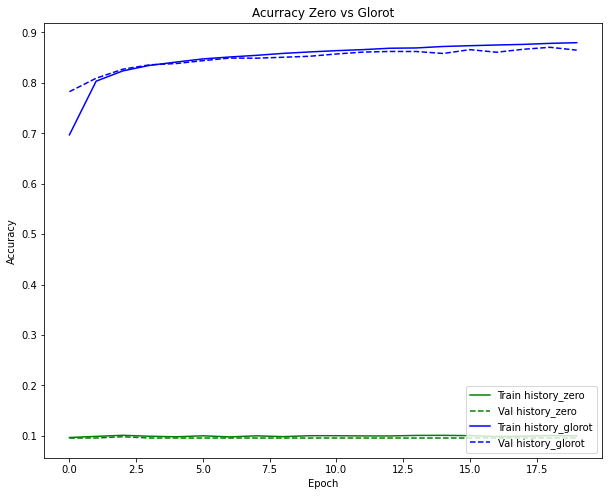

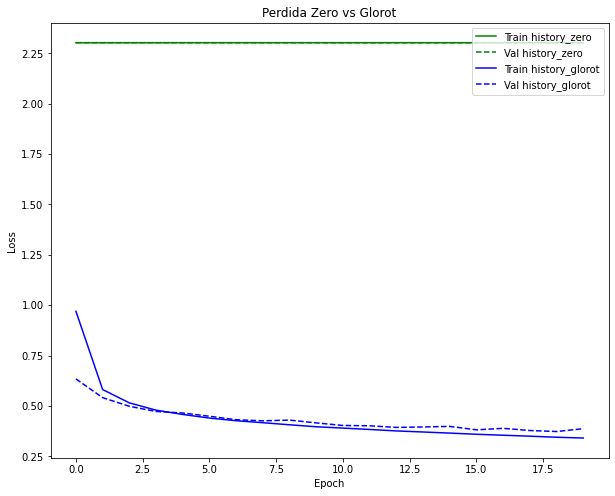

In [13]:
#Vamos a comparar el accuracy y las perdidas de cada modelo.
plot_compare_accs(history_zero, history_glorot, name1="history_zero",name2="history_glorot", title="Acurracy Zero vs Glorot")
plot_compare_losses(history_zero, history_glorot, name1="history_zero",name2="history_glorot", title="Perdida Zero vs Glorot")


#### Conclusión 3.1
Podemos apreciar que la inicialización Glorot uniform es mucho mejor que la que con ceros. De hecho, en la inicialización por 0 la función de perdida no decrece, es la peor situación ya que nuestra red neuronal no esta aprendiendo. Ocurre esta situación por que todas los paramentros tienen el mismo valor, esto hace que tengan el mismo peso de entrada, por lo que el gradiente repecto a los pesos es el mismo, lo paramentos cambiaran siempre de la misma manera y nuestra red no aprendera nada.

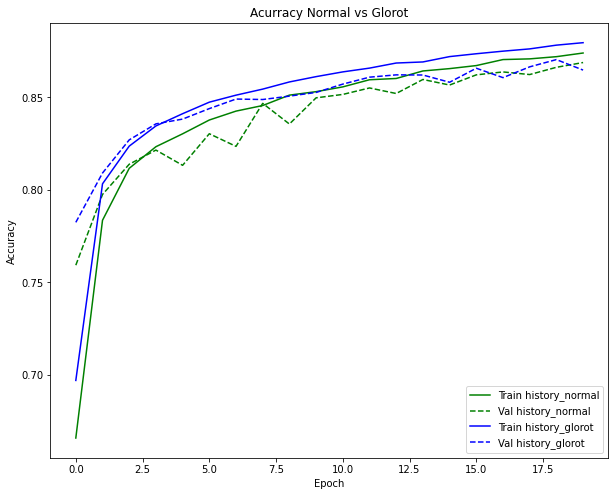

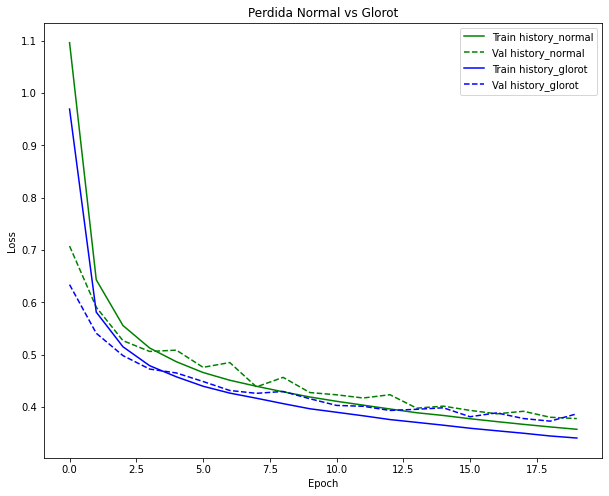

In [14]:
plot_compare_accs(history_normal, history_glorot, name1="history_normal",name2="history_glorot", title="Acurracy Normal vs Glorot")
plot_compare_losses(history_normal, history_glorot, name1="history_normal",name2="history_glorot", title="Perdida Normal vs Glorot")

#### Conclusión *3.2*

En este caso la inicialización por defecto Glorot uniform tiene mejor rendimiento que una inicialización aleatoria normal. Podemos ver que en ambos casos la función de perdida decrece, pero en las primeras epoch es cuando la inicialización por defecto se comporta mejor. Esto se debe a que Glorot tiende a que la varianza de salida de una neurona sea igual que la de entrada, esta situación hace que se acelere la convergencia al entrenar.

## 3. Optimizadores

**Ejercicio 3 ****: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

Experimento 4 - Adam vs SGD

In [15]:
def modelo_ejercicio3(activation,optimizer):

  model = Sequential()
  model.add(Dense(128,activation=activation, input_shape=(784,)))
  model.add(Dense(64,activation=activation))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,            
              metrics=['accuracy'])


  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [16]:
history_adam=modelo_ejercicio3('relu','adam')
history_RMSprop=modelo_ejercicio3('relu','RMSprop')




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
750/750 [==============================] - 6s 6ms/step - loss: 0.5331 - accuracy: 0.8139 - val_loss: 0.4203 - val_accuracy: 0.8470
Epoch 2/20
750/750 [==============================] - 5s 7ms/step - loss: 0.3895 - accuracy: 0.8604 - val_loss: 0.3804 - val_accuracy: 0.8625
Epoch 3/20
750/750 [========

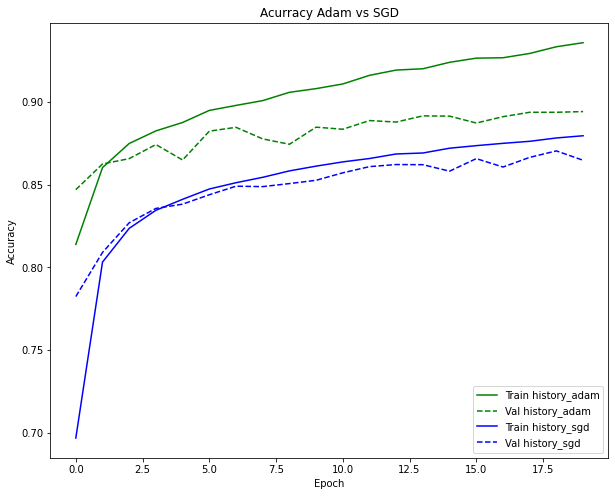

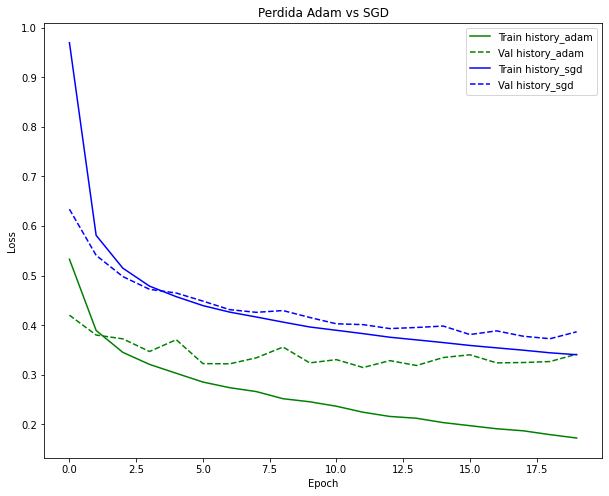

In [17]:
history_sgd= history_glorot
plot_compare_accs(history_adam, history_sgd, name1="history_adam",name2="history_sgd", title="Acurracy Adam vs SGD")
plot_compare_losses(history_adam, history_sgd, name1="history_adam",name2="history_sgd", title="Perdida Adam vs SGD")

#### Conclusión 

Estamos comparado Stochastic Gradient Descent, con un metodo adaptive learning rate. En este caso podemos apreciar que el optimiador ADAM se comporta mejor esto se debe a que utiliza una estrategia que los parámetros que se utilizan más a menudo tengan cambios más pequeños, por el contrario aquellos parámentros que se utilizan con menos actualizaciones de gradientes vean acelerada su learning reate. Cabe destacar que en las últimas epoch se aprecia el comienzo de Overfitting.

###Experimento 5 - RSMprop vs SGD

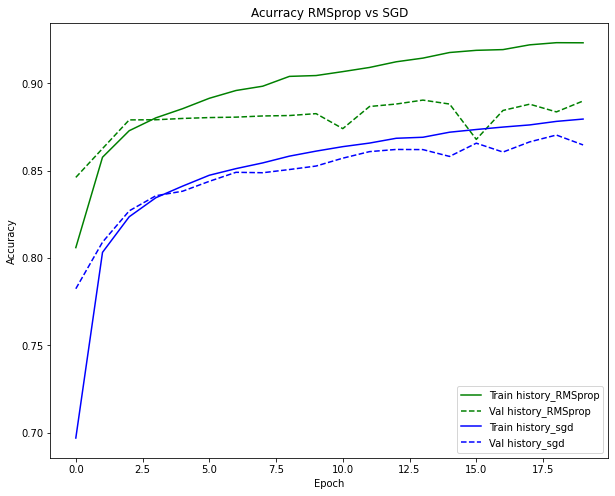

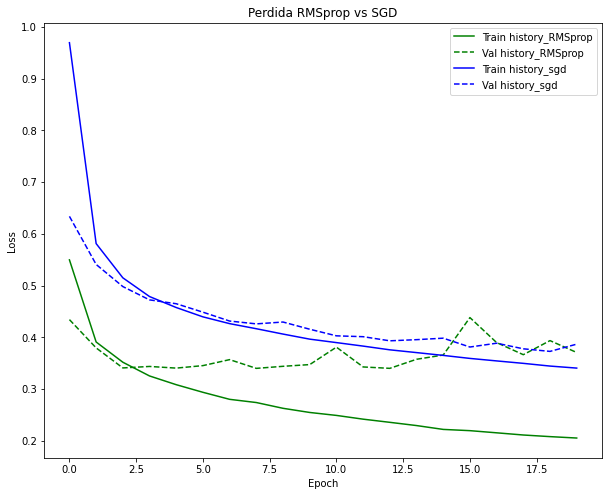

In [18]:
plot_compare_accs(history_RMSprop, history_sgd, name1="history_RMSprop",name2="history_sgd", title="Acurracy RMSprop vs SGD")
plot_compare_losses(history_RMSprop, history_sgd, name1="history_RMSprop",name2="history_sgd", title="Perdida RMSprop vs SGD")

#### Conclusión 

En este caso nos estamo comparando SGD con RSMprop. Podemos apreciar que aunque en la parte de entrenamiento RSMprop se comporta mejor a partir la epoch 5 se produce Overfitting. 

---



## 4. Regularización y red final 

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

### Experimento 6 - Adicción de más capas + early stopping

Vamos a añadir más capas a nuestra red y añadirle la técnica de regularización Earty stopping

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def modeloMasCapas():


  callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

  model = Sequential()
  model.add(Dense(512,activation='relu', input_shape=(784,)))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    callbacks=callbacks,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history




In [20]:
 history_mascapas=modeloMasCapas()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               401920    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 256)               65792     
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 10)                2570      
                                                                 
Total params: 733,194
Trainable params: 733,194
Non-tr

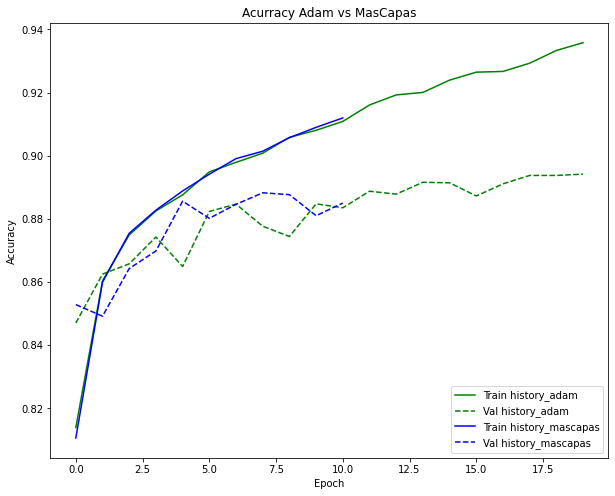

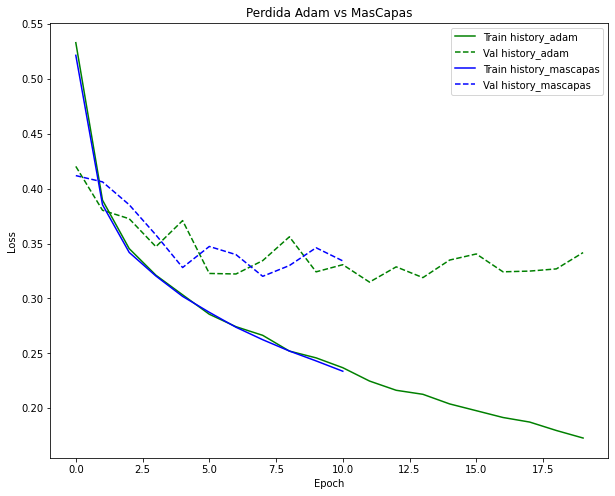

In [21]:
plot_compare_accs(history_adam, history_mascapas, name1="history_adam",name2="history_mascapas", title="Acurracy Adam vs MasCapas")
plot_compare_losses(history_adam, history_mascapas, name1="history_adam",name2="history_mascapas", title="Perdida Adam vs MasCapas")

###Conclusión
 Las gráficas son muy parecidas debido a que son arquitecturas muy sencilla, nos quedaria la duda que pasaria si no aplicaremos early stopping, debido a que el accurracy de validación de la red más simple es mejor en las últimas epocas.

###Experimento 7 - Adicción de más capas sin early stopping




Vamos a utilizar en este experimento la misma arquitectura del punto anterior pero sin early stopping. 

In [22]:
def modeloMasCapasSinES():



  model = Sequential()
  model.add(Dense(512,activation='relu', input_shape=(784,)))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history






In [23]:
  history_mascapasinES=modeloMasCapasSinES()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               401920    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 10)                2570      
                                                                 
Total params: 733,194
Trainable params: 733,194
Non-tr

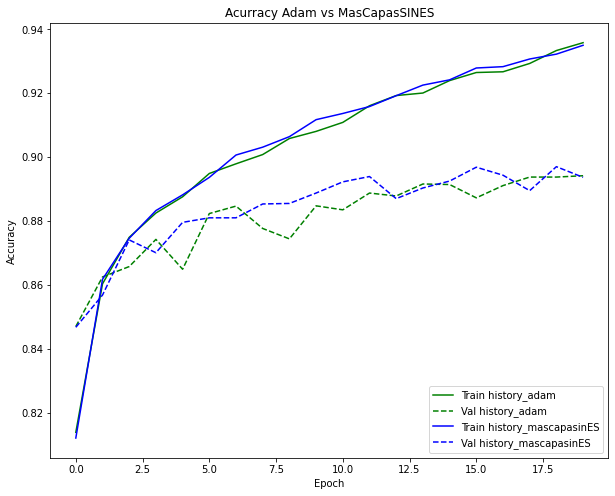

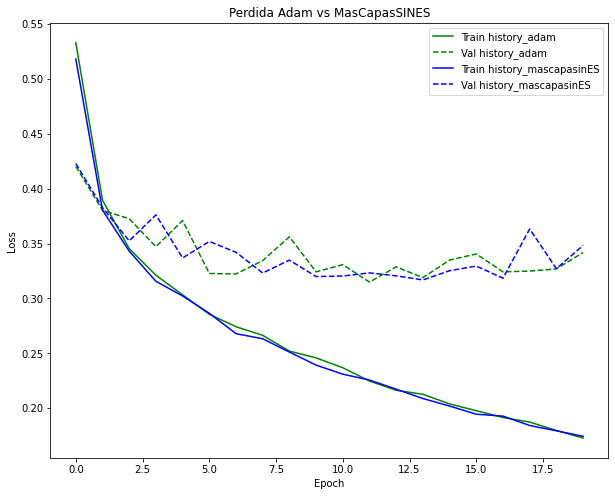

In [24]:
plot_compare_accs(history_adam, history_mascapasinES, name1="history_adam",name2="history_mascapasinES", title="Acurracy Adam vs MasCapasSINES")
plot_compare_losses(history_adam, history_mascapasinES, name1="history_adam",name2="history_mascapasinES", title="Perdida Adam vs MasCapasSINES")

#### Conclusión
Las gráficas son muy parecidas a efectos didacticos vamos a seguir con la arquitectura con  menos capas y sin early stopping. Debido a que es más rápida de entrenar y tiene menos overfitting.

###Experimento 8 - Aumento BatchSize




In [25]:
def modeloBatchSize():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation=activation, input_shape=(784,)))
  model.add(Dense(64,activation=activation))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history



In [26]:
  history_batchsize=modeloBatchSize()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               100480    
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 3s 10ms/step - loss: 0.6490 - accuracy: 0.7759 - val_loss: 0.4904 - val_accuracy: 0.8304
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4256 - accuracy: 0.8505 - val_loss: 0.4082 - val_accuracy: 0.8541
Epoch 3/20
188/188 [======

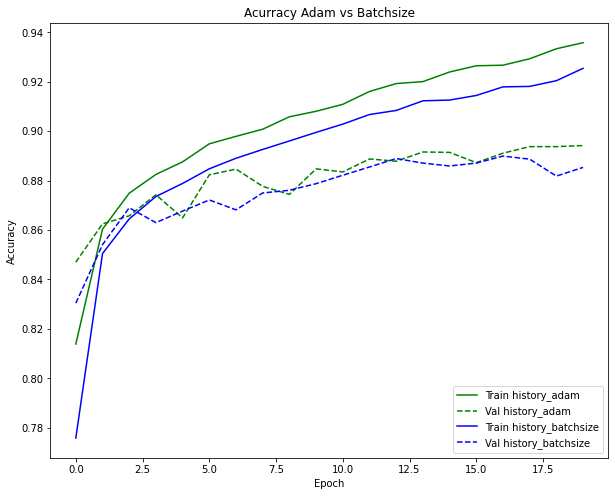

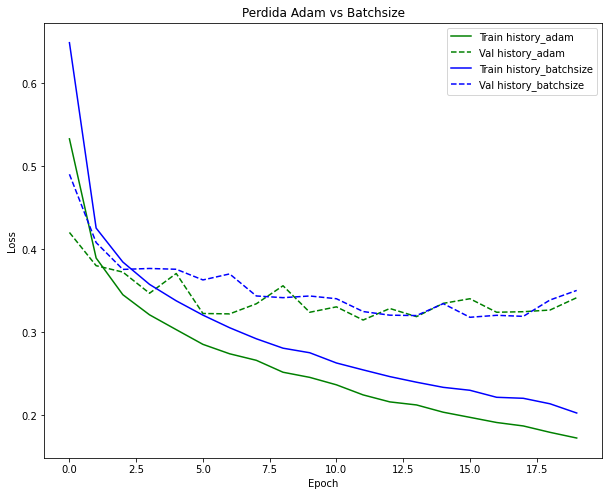

In [27]:
plot_compare_accs(history_adam, history_batchsize, name1="history_adam",name2="history_batchsize", title="Acurracy Adam vs Batchsize")
plot_compare_losses(history_adam, history_batchsize, name1="history_adam",name2="history_batchsize", title="Perdida Adam vs Batchsize")

Al aumentar el batch size optenemos mejores aproximaciones, vemos que la gráfica tiene menor overfitting y picos. A ser más uniforme vamos escoger este último para seguir con nuestros experimentos.

### Experimento 9 - Aplicar BatchNormalization

---



In [28]:
def modeloBatchNormalization():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation=activation, input_shape=(784,)))
  BatchNormalization()
  model.add(Dense(64,activation=activation))
  BatchNormalization()
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history


In [29]:
  history_batchnormalization=modeloBatchNormalization()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               100480    
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 3s 11ms/step - loss: 0.6486 - accuracy: 0.7806 - val_loss: 0.4754 - val_accuracy: 0.8295
Epoch 2/20
188/188 [==============================] - 2s 10ms/step - loss: 0.4248 - accuracy: 0.8523 - val_loss: 0.4050 - val_accuracy: 0.8587
Epoch 3/20
188/188 [=====

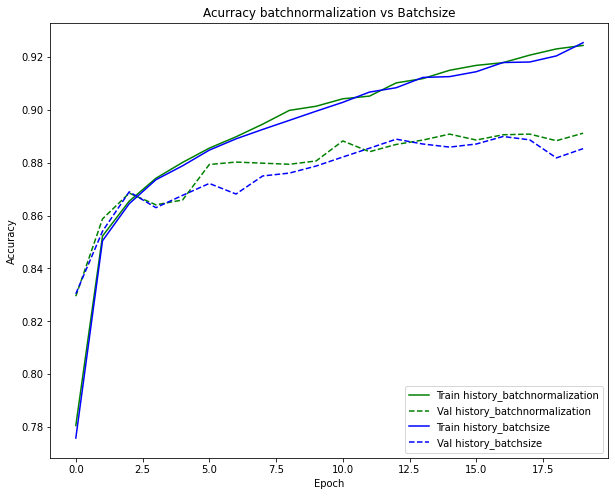

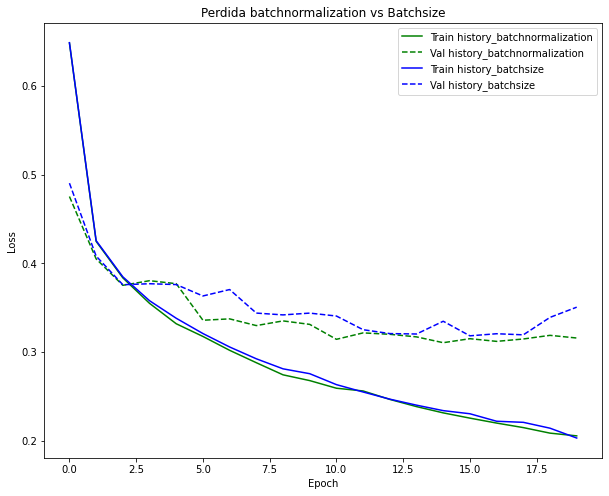

In [30]:
plot_compare_accs(history_batchnormalization, history_batchsize, name1="history_batchnormalization",name2="history_batchsize", title="Acurracy batchnormalization vs Batchsize")
plot_compare_losses(history_batchnormalization, history_batchsize, name1="history_batchnormalization",name2="history_batchsize", title="Perdida batchnormalization vs Batchsize")

#### Conclusión:
No apreciamos mejoria. Al ser una red muy pequeña la normalización no hace efecto debido a que la x que llega en cada capa es pequeña (wx + b), sólo tenemos una capa oculta.

### Experimento 10 - Aplicar regularización L2

*   Elemento de lista
*   Elemento de lista



In [31]:
from keras.regularizers import l2
def modeloRegularizacionL2():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01), input_shape=(784,)))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [32]:
history_l2=modeloRegularizacionL2()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               100480    
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 4s 14ms/step - loss: 1.4503 - accuracy: 0.7725 - val_loss: 0.7581 - val_accuracy: 0.8297
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.6598 - accuracy: 0.8322 - val_loss: 0.5933 - val_accuracy: 0.8412
Epoch 3/20
188/188 [======

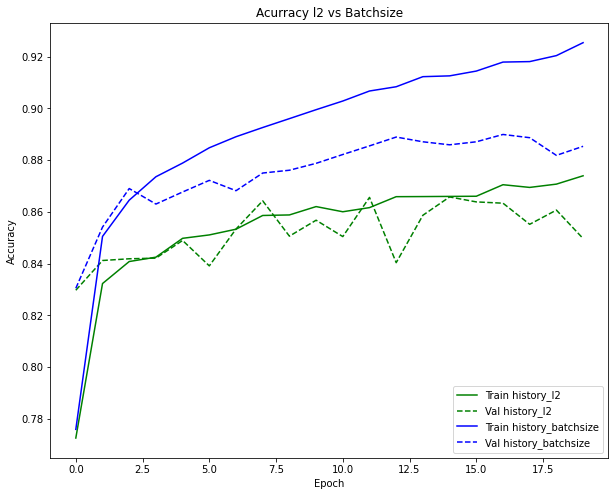

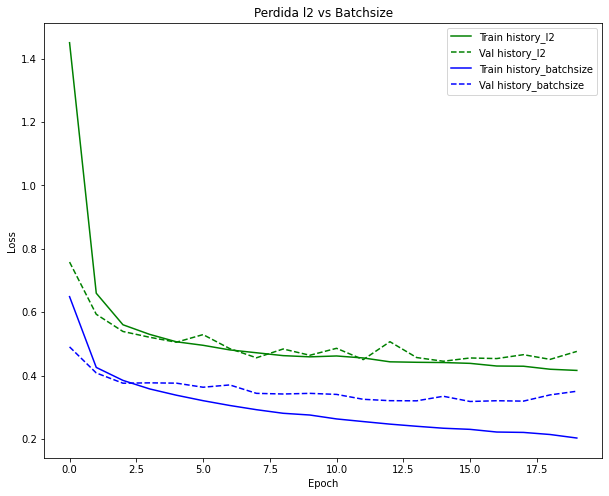

In [33]:
plot_compare_accs(history_l2, history_batchsize, name1="history_l2",name2="history_batchsize", title="Acurracy l2 vs Batchsize")
plot_compare_losses(history_l2, history_batchsize, name1="history_l2",name2="history_batchsize", title="Perdida l2 vs Batchsize")

#### Conclusión
No soluciona el problema de overfitting y el desempeño es menor por lo que desechamos este experimento.

### Experimento 11 - Aplicar regularización L1

In [34]:
from keras.regularizers import l1
def modeloRegularizacionL1():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation='relu',kernel_regularizer=l1(0.01), input_shape=(784,)))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [35]:
history_l1=modeloRegularizacionL1()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 128)               100480    
                                                                 
 dense_46 (Dense)            (None, 64)                8256      
                                                                 
 dense_47 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 4s 14ms/step - loss: 8.0241 - accuracy: 0.6661 - val_loss: 1.3395 - val_accuracy: 0.7473
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 1.2207 - accuracy: 0.7501 - val_loss: 1.1612 - val_accuracy: 0.7541
Epoch 3/20
188/188 [======

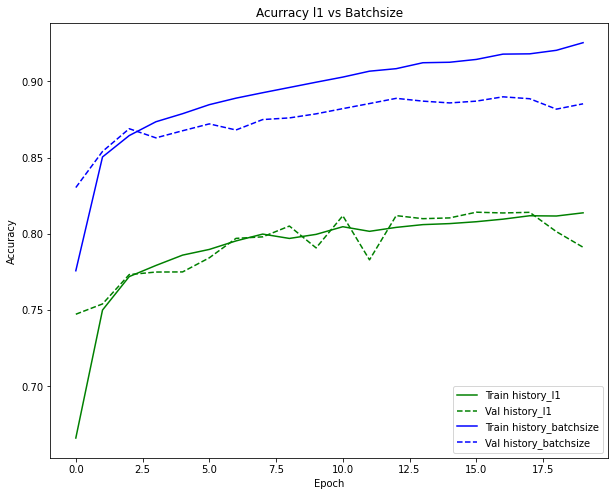

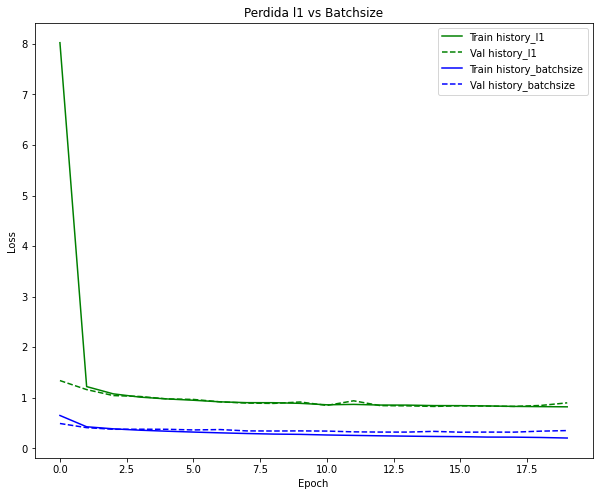

In [36]:
plot_compare_accs(history_l1, history_batchsize, name1="history_l1",name2="history_batchsize", title="Acurracy l1 vs Batchsize")
plot_compare_losses(history_l1, history_batchsize, name1="history_l1",name2="history_batchsize", title="Perdida l1 vs Batchsize")

#### Conclusión
No soluciona el problema de overfitting y el desempeño es menor por lo que desechamos este experimento. Llama la atención el salto en las primeras epocas en la funcion de perdida. Recordar que esta regularación tiende a que los parámetros se dispersen muchos se quedaban a "0" o cercanos. Esto en la inialización de una red neuronal es un factor en contra como hemos analizado en el experimento 3.

### Experimento 12 - Aplicar Dropout 0.2

In [37]:
def modeloDropOut():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation='relu', input_shape=(784,)))
  Dropout(0.2)
  model.add(Dense(64,activation='relu'))
  Dropout(0.2)
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [38]:
history_dropout= modeloDropOut()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               100480    
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 dense_50 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 3s 10ms/step - loss: 0.6443 - accuracy: 0.7819 - val_loss: 0.4562 - val_accuracy: 0.8407
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4267 - accuracy: 0.8508 - val_loss: 0.4036 - val_accuracy: 0.8589
Epoch 3/20
188/188 [======

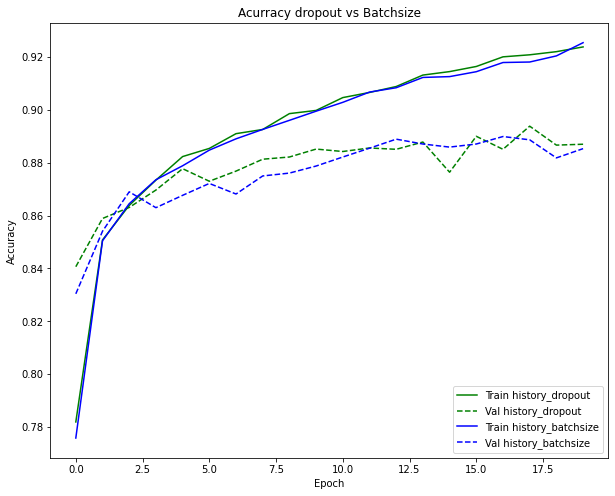

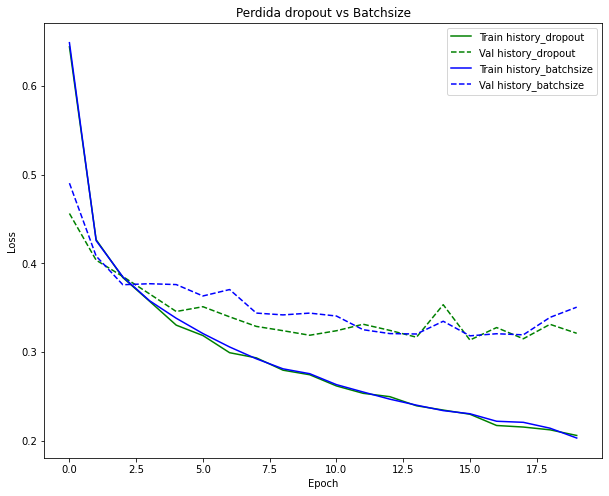

In [39]:
plot_compare_accs(history_dropout, history_batchsize, name1="history_dropout",name2="history_batchsize", title="Acurracy dropout vs Batchsize")
plot_compare_losses(history_dropout, history_batchsize, name1="history_dropout",name2="history_batchsize", title="Perdida dropout vs Batchsize")

Pese a tener menor desempeño la vamos a escoger debido a que así nuestra red no aprende sino va a generalizar.

###Experimento 13 - Aplicar Dropout 0.5

In [40]:
def modeloDropOut5():


  batch_size = 256
  model = Sequential()
  model.add(Dense(128,activation='relu', input_shape=(784,)))
  Dropout(0.5)
  model.add(Dense(64,activation='relu'))
  Dropout(0.5)
  model.add(Dense(num_clases,activation='softmax'))

  model.summary()


  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))

  return history

In [41]:
history_dropout5= modeloDropOut5()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               100480    
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 3s 11ms/step - loss: 0.6333 - accuracy: 0.7839 - val_loss: 0.4485 - val_accuracy: 0.8418
Epoch 2/20
188/188 [==============================] - 2s 10ms/step - loss: 0.4254 - accuracy: 0.8515 - val_loss: 0.4024 - val_accuracy: 0.8583
Epoch 3/20
188/188 [=====

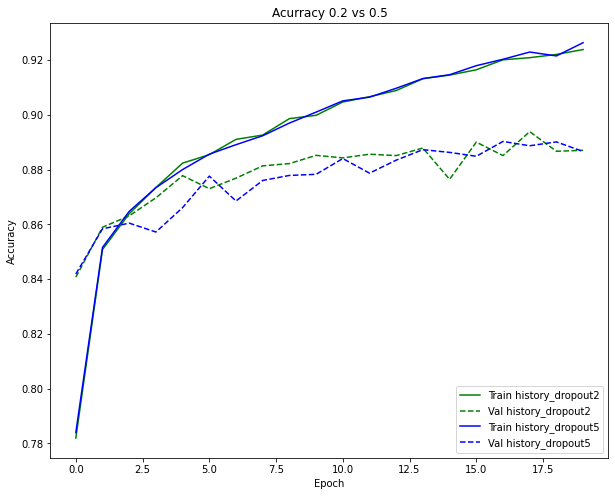

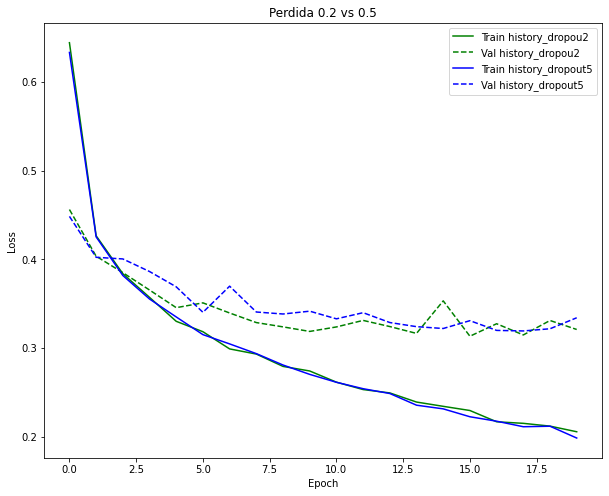

In [42]:
plot_compare_accs(history_dropout, history_dropout5, name1="history_dropout2",name2="history_dropout5", title="Acurracy 0.2 vs 0.5")
plot_compare_losses(history_dropout, history_dropout5, name1="history_dropou2",name2="history_dropout5", title="Perdida 0.2 vs 0.5")

#### Conclusión
 Generaliza mejor para este experimento nuestro modelo con 0.5, esta actuando como un ensemble de modelos, donde cambia en cada bacth, consiguiento entrenar un gran número de redes neuronales ligeramente distintas.

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

### Experimento 14, Análisis Accuracy

*   Elemento de lista
*   Elemento de lista



In [43]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 256
model = Sequential()
model.add(Dense(128,activation='relu', input_shape=(784,)))
Dropout(0.5)
model.add(Dense(64,activation='relu'))
Dropout(0.5)
model.add(Dense(num_clases,activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = 20,
                    verbose=1,
                    validation_data=(x_val, y_val))


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               100480    
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dense_56 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
188/188 [==============================] - 3s 10ms/step - loss: 0.6451 - accuracy: 0.7834 - val_loss: 0.4836 - val_accuracy: 0.8338
Epoch 2/20
188/188 [==============================] - 2s 9ms/step - loss: 0.4280 - accuracy: 0.8512 - val_loss: 0.4115 - val_accuracy: 0.8569
Epoch 3/20
188/188 [======

In [44]:
predictions = model.predict(x_test)
print(predictions)
score = model.evaluate(x_test, y_test,verbose=1)
print(score)


313/313 [==============================] - 1s 2ms/step
[[5.2550060e-08 8.0686219e-10 6.8116806e-06 ... 1.9243844e-03
  1.6328298e-07 9.9728745e-01]
 [1.6189286e-05 1.2921834e-12 9.9816430e-01 ... 6.1184205e-14
  4.2085060e-09 8.0460541e-11]
 [2.3553861e-07 9.9999970e-01 1.4319024e-09 ... 9.7097218e-16
  1.8820907e-11 1.0862988e-12]
 ...
 [3.1111721e-04 5.5038307e-10 3.3841043e-05 ... 7.5006259e-09
  9.9951881e-01 2.8314884e-09]
 [2.2929744e-06 9.9997979e-01 1.2711175e-06 ... 3.6746515e-13
  1.3402591e-07 4.4971453e-09]
 [1.3402463e-06 1.9524425e-07 2.5726729e-06 ... 1.9624477e-04
  1.1299344e-05 2.0585917e-06]]
313/313 [==============================] - 1s 2ms/step - loss: 0.3533 - accuracy: 0.8781
[0.35334378480911255, 0.8780999779701233]


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
                                          'Sneaker', 'Bag', 'Ankle boot']))

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.76      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.70      0.76      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.78      0.83      0.80      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.63      0.78      0.70      1000
     Sneaker       0.96      0.95      0.95      1000
         Bag       0.99      0.96      0.97      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



El resultado es muy bueno ya que los datos de validación son muy parecidos a los de predicición. Por ejemplo el acurracy de validación fue 0.8898 mientras que en test fue de 0.8780. Por lado también se puede apreciar que donde ha habido más problemas es en la clase Shirt. 